## PyTorch MLP model

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
from scipy.stats import uniform
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

### Loading training set and blind test set

In [2]:
df_visual = pd.read_csv('./data/ML-CUP21-TR.csv', usecols=[11,12], names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = pd.read_csv('./data/ML-CUP21-TR.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = df_task_tr[7:] # remove first 7 rows of comments
df_visual = df_visual[7:]

df_blind_ts = pd.read_csv('./data/ML-CUP21-TS.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10'])
df_blind_ts = df_blind_ts[7:]
df_blind_ts.drop(labels="idx", axis=1, inplace=True)
blind_ts = df_blind_ts.values

### Evaluation metrics

We define the <b>MEE (Mean Euclidean Error)</b> function which is used to evaluate the mean euclidean distance between two points with x and y coordinates.
The function takes in input the true target and the predicted target and yields a floating point number which represents the performance. 

In [3]:
def mee(true_target, predicted_target): #assuming target is 2-dim matrix with x and y as columns
    l = true_target.shape[0]
    res = 0
    
    for p in range(l): #for p-th pattern in l (number of samples)
        x_diff = np.square(true_target[p,0] - predicted_target[p,0]) #difference between the x value of the true and predicted target
        y_diff = np.square(true_target[p,1] - predicted_target[p,1]) #difference between the y values of true and predicted target
        sum_term = x_diff + y_diff
        res = res + np.sqrt(sum_term)
    res = res / l
    
    #return np.average([np.sqrt(np.square(true_target[p,0] - predicted_target[p,0]) + np.square(true_target[p,1] - predicted_target[p,1])) for p in range(l)]) #compact form
    return res

In [4]:
def inv_mee(true_target, predicted_target):
    return 1/mee(true_target, predicted_target)

## Regression task
### Preparing the training set

In [5]:
df_task_tr.drop(labels="idx", axis=1, inplace=True)

In [6]:
y = df_task_tr[['x','y']].values
X = df_task_tr.drop(labels=['x','y'], axis=1).values

In [7]:
print(X.shape)
print(y.shape)

(1477, 10)
(1477, 2)


In [8]:
RS_NUMBER = 69

### Splitting the dataset
We split the data set obtaining an internal test set (10% of the total dataset), we will use this internal test at the end to test internally the generalization error. The development set is composed of the other 90% of the total dataset, which is internally divided into 80% for training and 20% for validation. 

In [9]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state=RS_NUMBER)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RS_NUMBER)
print(f"X train shape: {X.shape}")
print(f"X validation shape: {X_test.shape}")
print(f"y train shape: {y.shape}")
print(f"y validation shape: {y_test.shape}")

X train shape: (1329, 10)
X validation shape: (148, 10)
y train shape: (1329, 2)
y validation shape: (148, 2)


### Define the module for the neural network
We define a Module for PyTorch, which takes as input the number of units, activation function (sigmoid, relu or tanh) and the number of hidden layers (can be either one or two). The model architecture is the simplest one of a MLP, one or two linear layers and the activation function.  

In [10]:
class MyModule(nn.Module):
    def __init__(self, num_units, activation_fun, hidden_layers):
        super(MyModule, self).__init__()
        
        if(activation_fun == "sigmoid"):
            activation_fun = nn.Sigmoid()
        elif activation_fun == "relu":
            activation_fun = nn.ReLU()
        elif activation_fun == "tanh":
            activation_fun = nn.Tanh()
            
        if hidden_layers == 2:
            self.linear_stack = nn.Sequential(
                nn.Linear(10, num_units),
                activation_fun,
                nn.Linear(num_units, num_units),
                activation_fun,
                nn.Linear(num_units, 2),
            )
        elif hidden_layers == 1:
            self.linear_stack = nn.Sequential(
                nn.Linear(10, num_units),
                activation_fun,
                nn.Linear(num_units, 2),
            )     
    def forward(self, x):
        X = self.linear_stack(x)
        return X
    
    def predict(self, x):
        X = self.linear_stack(x)
        return X

We define the device where the computation is going to happen (in our case the CPU) and we print a model example with a single hidden layer with 100 hidden units and the sigmoid activation function.  

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = MyModule(num_units=100, activation_fun = "sigmoid", hidden_layers = 1).to(device)
print(model)

MyModule(
  (linear_stack): Sequential(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=2, bias=True)
  )
)


Pytorch is used with skorch which is a wrapper for the framework, the goal of skorch is to make it possible to use PyTorch with sklearn. This will allow us to use the randomized search of sklearn, the NeuralNetRegressor takes the module defined before as input.

In [50]:
PATIENCE=15
THRESHOLD=0.001

In [51]:
model = NeuralNetRegressor(
    module = MyModule,
    callbacks=[('early_stoppping', EarlyStopping(monitor='valid_loss', patience=PATIENCE, threshold=THRESHOLD))],
)

In [52]:
# define the number of iterations
n_iter_search = 100
# define number of k-folds
k = 10

In [53]:
X = X.astype(np.float32)
y = y.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

### Randomized Search

In [54]:
#%%script false --no-raise-error

# to find the best set of parameter setting, we can run a randomized search

# define the parameters' values
params = {
    'lr': uniform(0.0001, 0.1),
    'max_epochs': [1000], #upper bound of max number of epochs
    'optimizer': [torch.optim.SGD],
    'optimizer__momentum': [0.8, 0.9, 0.95, 0.85], ##optimizer__ indicates that it is a parameter of the module
    'optimizer__weight_decay': [0.0001, 0.001, 0.01, 0.1, 1],
    'optimizer__nesterov': [False, True],
    'module__num_units': randint(5, 128), #module__ indicates that it is a parameter of the module
    'module__hidden_layers': [1,2],
    'module__activation_fun': ["sigmoid", "tanh", "relu"],
    'batch_size': randint(1, X.shape[0]),
}

# define the grid search
rand_gs = RandomizedSearchCV(
    model,
    param_distributions=params,
    n_iter=n_iter_search,
    n_jobs=-1,
    scoring=make_scorer(inv_mee), #scoring is based on the highest value so we use the inverse of the MEE loss function
    cv=k,
    random_state=RS_NUMBER,
    verbose=0
)
# run the grid search
rand_gs.fit(X, y)


In [55]:
#%%script false --no-raise-error

df_results = pd.DataFrame(data=rand_gs.cv_results_) #trasform into a pandas dataframe
df_results.sort_values(by="rank_test_score", axis=0, ascending=True, inplace=True) #sort rank values in decreasing order 
df_results.dropna(inplace=True) #delete nan values 
df_results = df_results[:50] #keep only top 50 models
pd.DataFrame.to_csv(df_results, "pytorch_results/pytorch_search.csv")

In [56]:
df_results = pd.read_csv("pytorch_results/pytorch_search.csv")
df_results.head()

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_lr,param_max_epochs,param_module__activation_fun,param_module__hidden_layers,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,22,27.719215,9.223068,0.009409,0.015485,1227,0.006878,1000,tanh,2,...,0.857545,0.828947,0.848353,0.884190,0.965212,0.821896,1.019920,0.904337,0.066813,1
1,28,18.195856,7.174137,0.008895,0.015738,662,0.074959,1000,sigmoid,1,...,0.812758,0.832114,0.831294,0.899238,0.919309,0.804899,1.012716,0.892424,0.068000,2
2,46,28.243947,10.114721,0.003433,0.000844,750,0.052956,1000,sigmoid,2,...,0.842784,0.854256,0.823047,0.909262,0.946888,0.801264,0.972250,0.887753,0.057975,3
3,37,11.086837,5.360469,0.007912,0.012871,412,0.077818,1000,sigmoid,1,...,0.812870,0.818432,0.810310,0.885294,0.943923,0.818563,0.996236,0.884162,0.065118,4
4,68,16.976698,10.289903,0.003851,0.000797,1118,0.021208,1000,tanh,1,...,0.825412,0.832298,0.824869,0.895260,0.919347,0.814973,0.959959,0.881260,0.055650,5


In [57]:
#get the best params for the grid search (cannot use rand_gs.best_estimator directly since it will yield the worst estimator based on MEE)
best_params = df_results['params'][0]
print(f"Mean error on the {k}-folds (invMEE) on best model: {df_results['mean_test_score'][0]}\n")
print(f"Best params: {best_params}")

Mean error on the 10-folds (invMEE) on best model: 0.9043367258342964

Best params: {'batch_size': 1227, 'lr': 0.006878206723193037, 'max_epochs': 1000, 'module__activation_fun': 'tanh', 'module__hidden_layers': 2, 'module__num_units': 102, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__momentum': 0.9, 'optimizer__nesterov': True, 'optimizer__weight_decay': 0.001}


### Retrain and evaluation of the best model

In [58]:
#TODO transform best_param_ into a dict (ast.literal_eval does not work)
HIDDEN_LAYERS=1
NUM_UNITS=116
ACTIVATION_FUN='sigmoid'

OPTIMIZER='SGD'
LR=0.037707577664514616
WEIGHT_DECAY = 0.0001

BATCH=61
EPOCHS=155
NESTEROV=False

MOMENTUM=0.95


In [59]:
def plot_learning_curves(train_scores, test_scores, epochs, y_label):
    plt.figure(figsize=(10,8))
    plt.plot(range(0,epochs), train_scores, label = "Training error", linestyle='dashed')
    plt.plot(range(0,epochs), test_scores, label = "Test error")
    plt.legend()
    plt.ylabel(y_label)
    plt.xlabel('Epoch');

In [60]:
#redefine the model with the best params
module = MyModule(NUM_UNITS, ACTIVATION_FUN, HIDDEN_LAYERS)
eval_module = MyModule(NUM_UNITS, ACTIVATION_FUN, HIDDEN_LAYERS)
#model.to(device)
print(module)

#criterion = nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=NESTEROV)

MyModule(
  (linear_stack): Sequential(
    (0): Linear(in_features=10, out_features=116, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=116, out_features=2, bias=True)
  )
)


In [61]:
#trains the model with one iteration (epoch) and computes in output a list of train and test scores using MEE
def fit_and_score(epochs, eval_model, X_train, y_train, X_test, y_test):
    train_scores = []
    test_scores = []
    train_loss = []
    test_loss = []
    eval_model.initialize()
    for i in range(epochs):
        eval_model = eval_model.fit_loop(X_train,y_train,1) #single epoch of the model
        y_train_predicted = eval_model.predict(X_train)
        y_test_predicted = eval_model.predict(X_test)
        #results on train set
        train_scores.append(mee(y_train, y_train_predicted))
        test_scores.append(mean_squared_error(y_test, y_test_predicted))
        #result on test set
        train_loss.append(mee(y_train, y_train_predicted))
        test_loss.append(mean_squared_error(y_test, y_test_predicted))
    return train_scores, test_scores, train_loss, test_loss


In [62]:
model = NeuralNetRegressor(
    module = module,
    criterion=nn.MSELoss,
    max_epochs=EPOCHS,
    lr=LR,
    batch_size=BATCH,
    optimizer=torch.optim.SGD,
    optimizer__momentum=MOMENTUM,
    callbacks=[('early_stoppping', EarlyStopping(monitor='valid_loss', patience=PATIENCE, threshold=THRESHOLD))],
)

eval_model = NeuralNetRegressor(
    module = eval_module,
    criterion=nn.MSELoss,
    max_epochs=BATCH,
    lr=LR,
    batch_size=BATCH,
    optimizer=torch.optim.SGD,
    optimizer__momentum=MOMENTUM,
)

In [63]:
model.fit(X, y)
y_predicted = model.predict(X)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       82.9940       29.1065  0.0313
      2       17.7395        6.9048  0.0300
      3        4.0597        2.5785  0.0297
      4        2.2923        1.5893  0.0298
      5        1.6873        1.2984  0.0333
      6        1.4219        1.0763  0.0302
      7        1.2432        0.9918  0.0292
      8        1.1890        0.9794  0.0302
      9        1.1532        0.9917  0.0292
     10        1.1352        0.9901  0.0298
     11        1.1146        0.9788  0.0302
     12        1.0956        0.9741  0.0304
     13        1.0843        0.9721  0.0290
     14        1.0752        0.9713  0.0296
     15        1.0706        0.9710  0.0344
     16        1.0665        0.9718  0.0292
     17        1.0639        0.9733  0.0288
     18        1.0615        0.9758  0.0288
     19        1.0595        0.9790  0.0288
     20        1.0573        0.9831  0.0289
     21        1.0554        0.9

In [64]:
print(f"MEE: {mee(y, y_predicted)}")

MEE: 1.0119809907047461


In [65]:
y_predicted_test = model.predict(X_test)
print(f"MEE: {mee(y_test, y_predicted_test)}")

MEE: 1.0796307414971493


In [66]:
#history = model.history
#train_loss = history[:, 'train_loss']
#test_loss = history[:, 'valid_loss']

In [67]:
train_scores, test_scores, train_loss, test_loss = fit_and_score(69, eval_model, X, y, X_test, y_test)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       84.6922       20.2642  0.0345
      2       20.3280        4.1096  0.0295
      3        6.1549        4.3067  0.0295
      4        3.8345        1.5533  0.0304
      5        2.2011        1.3784  0.0333
      6        1.6429        1.4460  0.0301
      7        1.4219        1.2050  0.0298
      8        1.2449        1.0853  0.0331
      9        1.2144        1.0432  0.0341
     10        1.1671        1.0150  0.0295
     11        1.1532        1.0017  0.0299
     12        1.1513        0.9790  0.0300
     13        1.1446        0.9511  0.0308
     14        1.1388        0.9283  0.0336
     15        1.1257        0.9140  0.0297
     16        1.1060        0.9102  0.0307
     17        1.0818        0.9077  0.0378
     18        1.0577        0.9022  0.0378
     19        1.0375        0.8970  0.0295
     20        1.0223        0.8942  0.0296
     21        1.0120        0.8

## Loss Curves

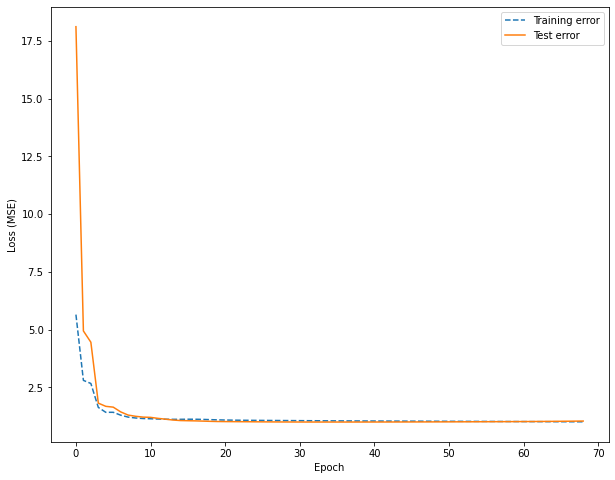

In [68]:
plot_learning_curves(train_scores, test_scores, 69, "Loss (MSE)")

## Learning Curves

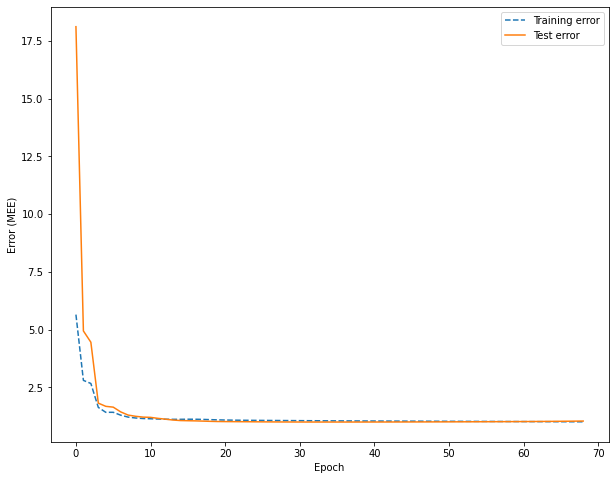

In [69]:
plot_learning_curves(train_scores, test_scores, 69, "Error (MEE)")

In [31]:
class CupDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
train_dataset = CupDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = CupDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = CupDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

In [32]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [33]:
#redefine the model with the best params
model = MyModule(NUM_UNITS, ACTIVATION_FUN, HIDDEN_LAYERS)
model.to(device)
print(model)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=NESTEROV)

MyModule(
  (linear_stack): Sequential(
    (0): Linear(in_features=10, out_features=116, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=116, out_features=2, bias=True)
  )
)


In [34]:
loss_stats = {
    'train': [],
    "val": []
}

In [35]:
#function to define the train phase
def TrainPhase_Cup(epochs, model, aggregated_losses, aggregated_accuracy, data_train, loss, optimizer):
    model.train()
    i = epochs

    epoch_loss = 0
    epoch_acc = 0
    
    for X_batch, y_batch in data_train:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
       
        y_pred = model(X_batch)
        #y_pred1 = model(X_batch)
        
        single_loss = loss(y_pred, y_batch)
        #single_loss1 = loss1(y_pred1, y_batch1)
        #single_loss2 = loss2(y_pred2, y_batch2)
        #single_loss = torch.add(single_loss1, single_loss2)

        #acc = binary_acc(y_pred, y_batch)
             
        single_loss.backward()
        optimizer.step()
        
        epoch_loss += single_loss.item()
        #epoch_acc += acc.item()
        
    aggregated_losses.append(epoch_loss/len(data_train))
    #aggregated_accuracy.append((epoch_acc/len(data_train))/100)
    print(f'TRAIN - Epoch {i+0:03}: | Loss: {epoch_loss/len(data_train):.5f}')

    #aggregated_losses.append(single_loss.item())
    #aggregated_accuracy.append(acc/100)
    #print(f'TRAIN - Epoch {i+0:03}: | Loss: {single_loss.item():.5f} | Acc: {acc:.3f}')
    
    return model, aggregated_losses

In [36]:
#function to define the evaluate phase
def Evaluate_Cup(epochs, model, aggregated_losses, aggregated_accuracy, data_test, loss_f):
    
    i = epochs
    y_pred_list = []
    model.eval()
        
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for X_batch, y_batch in data_test:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_test_pred = model(X_batch)
            #y_pred1, y_pred2 = model(X_batch)

            loss = loss_f(y_test_pred, y_batch)
            #loss1 = loss_f1(y_pred1, y_batch1)
            #loss2 = loss_f2(y_pred2, y_batch2)
            #loss = torch.add(loss1, loss2)
            
            #acc = binary_acc(y_test_pred, y_batch)

            epoch_loss += loss.item()
            #epoch_loss += loss.item()*X_batch.size(0)
            #epoch_acc += acc.item()

            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
    

    #y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

    aggregated_losses.append(epoch_loss/len(data_test))
    #aggregated_accuracy.append((epoch_acc/len(data_test))/100)
    #print(f'TEST - Epoch {i+0:03}: | Loss: {epoch_loss/len(data_test):.5f} | Acc: {epoch_acc/len(data_test):.3f}')
    print(f'VALIDATION - Epoch {i+0:03}: | Loss: {epoch_loss/len(data_test):.5f}')
    
    return aggregated_losses
    

In [37]:
#function to define the evaluate phase
def Result_Cup(model, X_batch):
    
    y_pred_list = []
    model.eval()

    with torch.no_grad():
        #for X_batch, _ in data_test:
        X_batch = X_batch.to(device)

        y_test_pred = model(X_batch)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy()) 

    #y_pred_list = [a.squeeze().tolist() for a in y_pred_list]    
    return y_pred_list
    

In [38]:
#prepare empty lists to store accuracy and loss results
losses_train = []
accuracies_train = []
losses_test = []
accuracies_test = []

#train and evaluate for each epoch
for epoch in range(1,EPOCHS+1): 
  model, losses_train = TrainPhase_Cup(epoch, model, losses_train, accuracies_train, train_loader, criterion, optimizer)
  #y_pred_test, losses_test, accuracies_test = Evaluate(epoch, model, losses_test, accuracies_test, test_loader, loss_function)
  losses_test = Evaluate_Cup(epoch, model, losses_test, accuracies_test, val_loader, mee)
  
  print("##############################")

TRAIN - Epoch 001: | Loss: 75.39355
VALIDATION - Epoch 001: | Loss: 3.99515
##############################
TRAIN - Epoch 002: | Loss: 14.23014
VALIDATION - Epoch 002: | Loss: 3.93297
##############################
TRAIN - Epoch 003: | Loss: 7.04968
VALIDATION - Epoch 003: | Loss: 2.90387
##############################
TRAIN - Epoch 004: | Loss: 3.09391
VALIDATION - Epoch 004: | Loss: 2.08815
##############################
TRAIN - Epoch 005: | Loss: 2.19823
VALIDATION - Epoch 005: | Loss: 1.54854
##############################
TRAIN - Epoch 006: | Loss: 1.66930
VALIDATION - Epoch 006: | Loss: 1.37279
##############################
TRAIN - Epoch 007: | Loss: 1.34824
VALIDATION - Epoch 007: | Loss: 1.27762
##############################
TRAIN - Epoch 008: | Loss: 1.38243
VALIDATION - Epoch 008: | Loss: 1.33110
##############################
TRAIN - Epoch 009: | Loss: 1.24222
VALIDATION - Epoch 009: | Loss: 1.21770
##############################
TRAIN - Epoch 010: | Loss: 1.12690
VALIDATIO

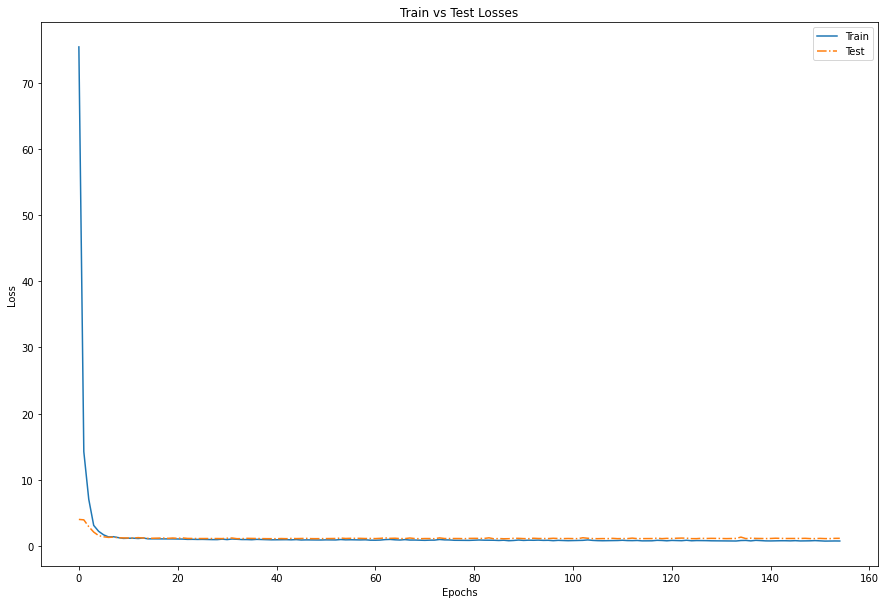

In [39]:
#create a loss plot
plt.figure(figsize=(15,10))
plt.plot(losses_train,'-')

plt.plot(losses_test,'-.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')
 
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d9d840c9-75b3-4185-bb01-105f5cca8d83' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>